# [Immigration to Canada](https://github.com/XutongJiang/ImmigrationToCanada)

### Group members
Section 003: *Xutong Jiang*, *Danny Liu*.  
Section 004: *Jasper Zhao*, *Yan Zeng*.

### Background
This is the final project for ECON 323 at UBC, Vancouver.  
The rising cost of living in Canada is becoming a big problem for many Canadians, especially for new settlers. As an immigrant, choosing the best place to reside in Canada can be a challenging task influenced by a range of factors. Our project aims to provide valuable insights to assist new immigrants in making wise decisions regarding housing rental, income by profession, and living expenses. We achieve this by utilizing data from government sources and presenting it in a visually appealing manner. By offering data-driven insights, our project can guide immigrants as they take their first steps toward settling in Canada.

### Dataset

We gathered 6 datasets from Statistics Canada. These datasets revolve around 3 aspects that we thought were important to our target users (people who are planning their move to Canada). These aspects are rent price, income by occupation and household spending across Canada.  

The datasets are listed below:  

1. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410013301 (average rents for areas with a population of 10,000 and over)
2. https://www150.statcan.gc.ca/n1/daily-quotidien/220323/t002a-eng.htm (Median after-tax income, Canada and provinces, 2020)
3. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810045201 (Employment income statistics by occupation minor group, work activity during the reference year, age and gender: Canada, provinces and territories and census metropolitan areas with parts)
4. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610022501&pickMembers%5B0%5D=1.11&pickMembers%5B1%5D=2.1&cubeTimeFrame.startYear=2020&cubeTimeFrame.endYear=2020&referencePeriods=20200101%2C20200101 (Detailed household final consumption expenditure, provincial and territorial, annual (x 1,000,000))
5. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410032501 (Job vacancies, payroll employees, job vacancy rate, and average offered hourly wage by provinces and territories, quarterly, unadjusted for seasonality)
6. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410035601&pickMembers%5B0%5D=1.2&cubeTimeFrame.startMonth=07&cubeTimeFrame.startYear=2021&cubeTimeFrame.endMonth=07&cubeTimeFrame.endYear=2022&referencePeriods=20210701%2C20220701 (Job vacancies and average offered hourly wage by occupation)
7. Statistics Canada. Table 17-10-0009-01  Population estimates, quarterly https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
try:
    import geopandas as gpd
    import folium
except ImportError:
    ! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes

    
df1 = pd.read_csv("data/1-Rent.csv")
df2 = pd.read_csv("data/2-Income.csv")
df3 = pd.read_csv("data/3-IncomeByOccupation.csv")
df4 = pd.read_csv("data/4-Spending.csv")
df5 = pd.read_csv("data/5-Vacancy&Wage.csv")
df6 = pd.read_csv("data/6-Occupation&Vacancy&Wage.csv")
df7 = pd.read_csv("data/7-Household_expenditure.csv", index_col=[0,1],dtype={0: str, 1: str})
df8 = pd.read_csv("data/8-Population.csv")
income_vs_cost = pd.read_csv("data/Aggregated-2,4,5,7.csv")
province_code = {
  "Newfoundland and Labrador": "NL",
  "Alberta": "AB",
  "British Columbia": "BC",
  "Manitoba": "MB",
  "New Brunswick": "NB",
  "Nova Scotia": "NS",
  "Ontario": "ON",
  "Prince Edward Island": "PE",
  "Quebec": "QC",
  "Saskatchewan": "SK",
  "Nunavut": "NU",
  "Northwest Territories": "NT",
  "Yukon Territory": "YT"    
}

### Preprocessing
Before implementing the Analysis, it's important to clean up and process the original dataset. We have the following pipeline to preprocess data:
1. Grouping data by provinces to maintain consistancy across datasets. Since in dataset 1, the geographical locations are cities while in all other datasets, geographical locations are provinces, we need to first extract each row’s corresponding province and group the data by their provinces. Finally, we are going to derive attribute Rent by taking the mean of rents of each specific unit type across the province.
2. For datasets 2, 4 and 5, we are joining them together on the Province attribute. The number of rows won’t change since in the original datasets, each province is corresponding to one row and one quantitative attribute value.
3. We will also join dataset 3 and 6, by the unique identifier Province + Occupation. For occupations, we keep only the top levels in this table, as the corresponding visualization would only need that degree of information.
4. We will perform data cleaning on df7 and df8. Since df7 is the total house hold expenditure in a geographic area divided by 1,000,000, we need to merge it with df8 to get the population of each geographic area and multiply it by 1,000,000 and then divided it by the population to get the average expenditure for each individual.
5. Lastly, we transform each province name to province code instead, as some names are quite long and later may cause label overlapping on the visualization.

In [2]:
# Step 1
df1['Province'] = df1['Province'].apply(lambda x: x.split(', ')[1])
df1 = df1.groupby(['Province','Unit'])['Rent'].mean().reset_index()

# Step 2
df245 = pd.merge(df2, df4, on='Province').merge(df5, on='Province')

# Step 3
df36 = pd.merge(df3, df6, on=['Province','Occupation'])

# Step 4
for col in df7.columns:
    df7[col] = df7[col].str.replace(',', '').astype(float)
for col in df8.columns:
    if (col=="Geography"):
        continue
    df8[col] = df8[col].str.replace(',', '').astype(float)
melted_df8 = pd.melt(df8, id_vars=["Geography"], var_name='Time', value_name='Population')
pivoted_df8 = melted_df8.pivot_table(index=["Geography","Time"])
expenditure_population = pd.merge(df7,pivoted_df8, how="inner", left_on=["Geography","Time"], right_on=["Geography","Time"])
df_no_pop = expenditure_population.drop('Population', axis=1)
expenditure_population['Population']
def convert_to_individual(row):
    population = row['Population']
    new_row = row.copy()
    for column in row.index:
        if column != 'Population':
            new_row[column] = (row[column] * 1000000) / population
    return new_row
individual_consumption = expenditure_population.apply(convert_to_individual, axis=1)

# Step 5    
def translate_province(df):
    df['Province'] = df['Province'].apply(lambda x: province_code.get(x))
translate_province(df1)
translate_province(df245)
translate_province(df36)



In [3]:
df1.head()

,Province,Unit,Rent
0,AB,Bachelor units,852.400000
1,AB,One bedroom units,1005.470588
2,AB,Three bedroom units,1301.125000
3,AB,Two bedroom units,1185.210526
4,BC,Bachelor units,908.700000


In [4]:
df245.head()

,Province,Income,Spending,Vacancy,Rate,Wage
0,NL,59300,14930.4,"8,185",3.7,22.3
1,PE,59400,4207.1,"4,090",5.4,19.5
2,NS,57500,26161.7,"22,960",5.2,20.8
3,NB,56900,21062.6,"16,430",4.7,20.9
4,QC,59700,220364.2,"246,230",6.1,23.7


In [5]:
df36.head()

,Province,Occupation,Income,Vacancy,Wage
0,NL,Legislative and senior management,97000,275,33.30
1,NL,"Business, finance and administration",47200,595,23.25
2,NL,Natural and applied sciences,78500,295,35.00
3,NL,Health,55200,"1,480",27.45
4,NL,"Education, Law and Public Services",44800,710,20.65


In [6]:
df5.head()

,Province,Vacancy,Rate,Wage
0,Newfoundland and Labrador,"8,185",3.7,22.3
1,Prince Edward Island,"4,090",5.4,19.5
2,Nova Scotia,"22,960",5.2,20.8
3,New Brunswick,"16,430",4.7,20.9
4,Quebec,"246,230",6.1,23.7


In [7]:
individual_consumption.head()

Total consumption  Food and beverages     Tobacco  \
Geography Time                                                      
Canada    2000       19134.244840         1835.793169  302.137778   
          2001       19762.171875         1919.456828  325.707901   
          2002       20717.597906         1980.429460  391.329402   
          2003       21463.539345         2037.282339  422.492134   
          2004       22251.589024         2093.167473  425.843242   

                   Clothing  Housing and utilities  Household appliance  \
Geography Time                                                            
Canada    2000   954.977573            4370.683975          1100.053083   
          2001   981.910217            4496.593688          1151.269331   
          2002  1000.611603            4643.714101          1222.888484   
          2003  1007.660596            4854.358684          1273.053336   
          2004  1024.657990            5026.442137          1330.588469   

                    Health    Transport  Communications  \
Geography Time                                            
Canada    2000  639.423721  2862.009119      410.765746   
          2001  688.230207  2874.703907      439.267170   
          2002  740.785159  3060.464272      481.276662   
          2003  775.477396  3135.119122      497.512924   
          2004  826.686451  3228.094018      524.750984   

                Recreation and culture   Education  \
Geography Time                                       
Canada    2000             1897.188761  220.504380   
          2001             1972.975849  230.748580   
          2002             2056.546018  248.094193   
          2003             2097.116224  268.322993   
          2004             2154.028974  283.614595   

                Insurance and financial services       Others  Population  
Geography Time                                                             
Canada    2000                       1647.545838   968.491100  30783969.0  
          2001                       1668.983950  1004.814817  31129119.0  
          2002                       1775.162754  1054.090321  31451764.0  
          2003                       1822.397087  1086.966488  31737869.0  
          2004                       1942.574271  1135.769244  32039959.0

## Data Visualization as a brief introduction of Canada

As a new immigrant, people are most concerned about a few aspects of a country, namely the cost of living and employment. Next, we will visualize the data we have collected, so that new immigrants can have a more intuitive understanding of Canada.

### The population of Canada

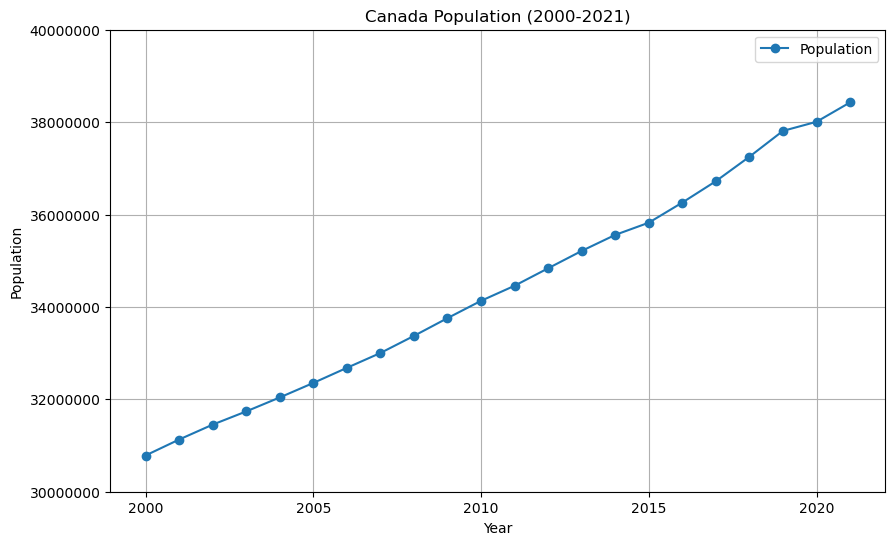

In [8]:
pop_ca = pd.DataFrame(individual_consumption.loc["Canada","Population"])
pop_ca.plot(figsize=(10, 6),marker='o')
plt.xlabel("Year")
plt.ylabel("Population")
plt.ticklabel_format(style='plain', axis='y')
plt.title("Canada Population (2000-2021)")
plt.ylim(30000000, 40000000)
plt.grid()
plt.show()

As we can see from the graph above, population increase in Canada is steady and sustained over time. 

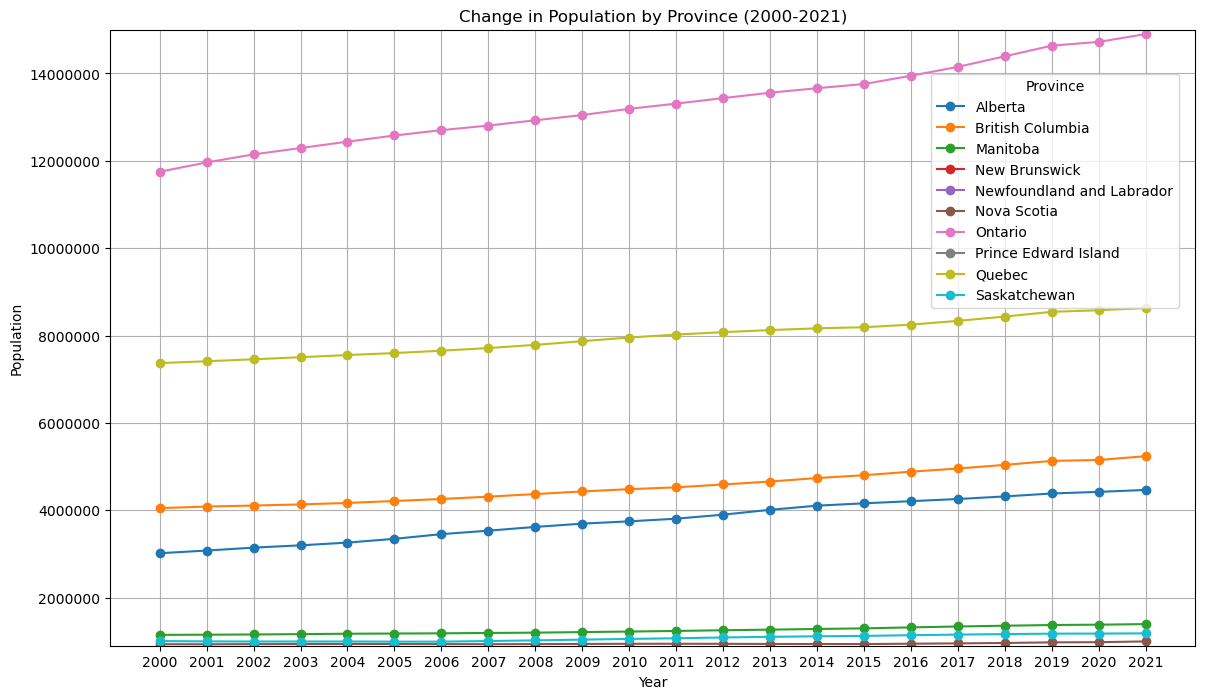

In [9]:
population = pd.DataFrame(individual_consumption["Population"].drop(index=["Canada"],level=0)).pivot_table(index="Time", columns="Geography", values="Population")
plt.figure(figsize=(14, 8))
for column in population.columns:
    plt.plot(population.index, population[column], marker='o', label=column)
plt.xlabel("Year")
plt.ylabel("Population")
plt.ticklabel_format(style='plain', axis='y')
plt.title("Change in Population by Province (2000-2021)")
plt.ylim(900000, 15000000)
plt.legend(bbox_to_anchor=(0.75, 0.94), loc='upper left', fontsize=10, title="Province")
plt.grid()
plt.show()

Each province has its own population growth rate. From the plot above we can see that Ontario has the largest population in Canada, followed by Quebec and British Columbia. Whereas the prairie provinces has the least population.

### Cost of Living
We would like to visualize the overall cost of living in each province
1. The total cost of living per person in each Province from 2000 - 2021


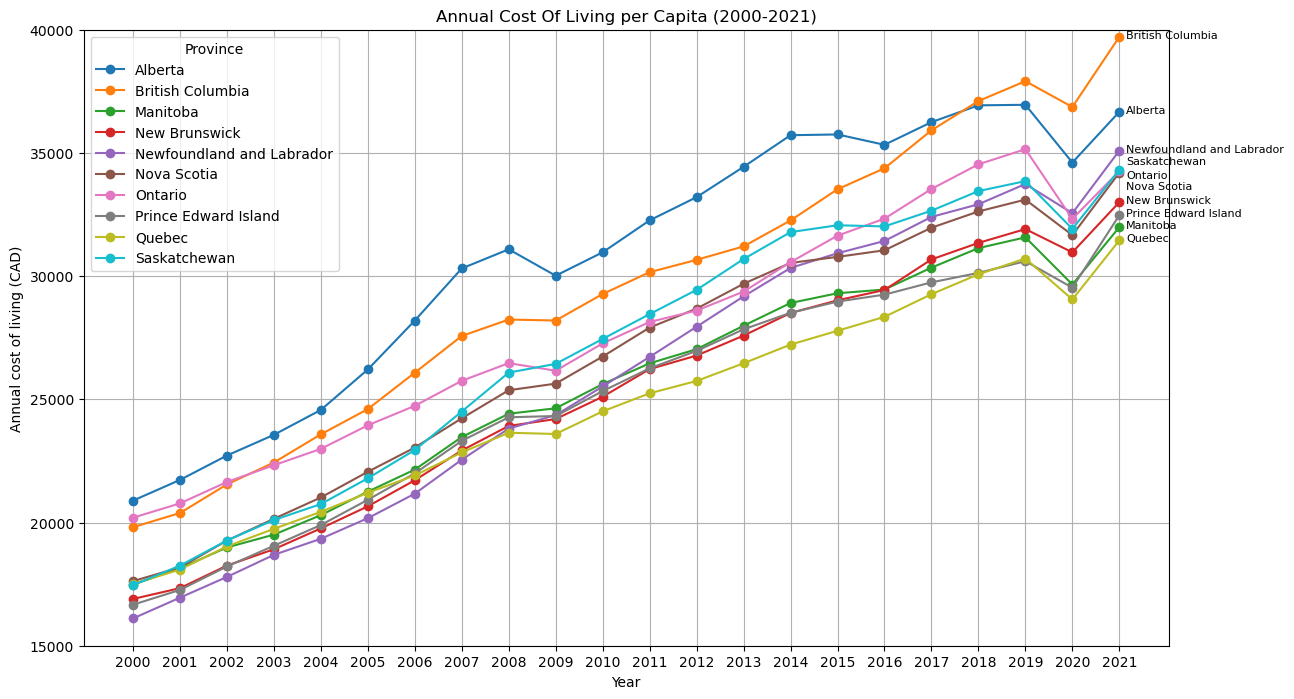

In [10]:
consumption = pd.DataFrame(individual_consumption["Total consumption"].drop(index=["Canada"],level=0)).pivot_table(index="Time", columns="Geography", values="Total consumption")
plt.figure(figsize=(14, 8))
for column in consumption.columns:
    plt.plot(consumption.index, consumption[column], marker='o', label=column)
    last_point = consumption[column].iloc[-1]
    if (column == "Saskatchewan"):
        plt.annotate(column, (consumption.index[-1], last_point), textcoords="offset points", xytext=(5, 4), ha='left', fontsize=8)
        continue
    elif (column == "Ontario"):
        plt.annotate(column, (consumption.index[-1], last_point), textcoords="offset points", xytext=(5, -5), ha='left', fontsize=8)
        continue
    elif (column == "Nova Scotia"):
        plt.annotate(column, (consumption.index[-1], last_point), textcoords="offset points", xytext=(5, -12), ha='left', fontsize=8)
        continue
    
    plt.annotate(column, (consumption.index[-1], last_point), textcoords="offset points", xytext=(5, -1), ha='left', fontsize=8)

plt.xlabel("Year")
plt.ylabel("Annual cost of living (CAD)")
plt.ticklabel_format(style='plain', axis='y')
plt.title("Annual Cost Of Living per Capita (2000-2021)")
plt.ylim(15000, 40000)
plt.legend(loc='upper left', fontsize=10, title="Province")
plt.grid()
plt.show()

2. The percentage of each category in total expenditure by province in 2021

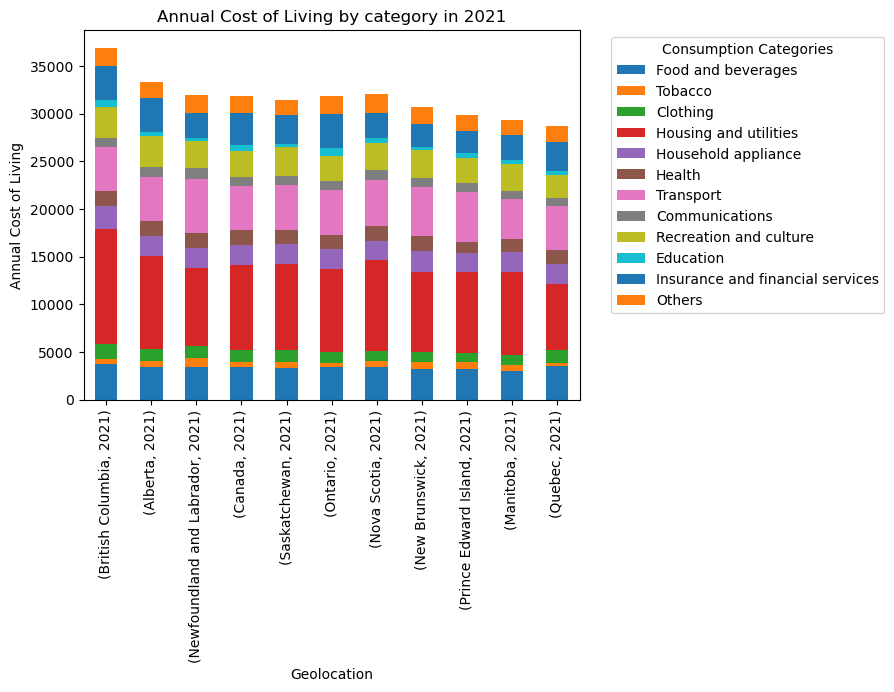

In [11]:
consumption_2021 = individual_consumption.sort_values("Total consumption",ascending=False).loc[pd.IndexSlice[:,"2021"],:].drop(columns=["Total consumption", "Population"])
ax = consumption_2021.plot(kind='bar', stacked=True)
plt.xlabel('Geolocation')
plt.ylabel('Annual Cost of Living')
plt.title('Annual Cost of Living by category in 2021')
plt.legend(title='Consumption Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Housing and utilities constitutes the most part of annual expenditure. British Columbia has the highest cost of living, whereas Quebec has the lowest.

3. We visualized the data from Statistics Canada about the average rent for bachelor units, one bedroom units, two bedroom units and three bedroom units in each province. The original dataset contains detailed data for each city. But in order to give new immigrants an intuition about each region, we aggregated those cities into provinces.

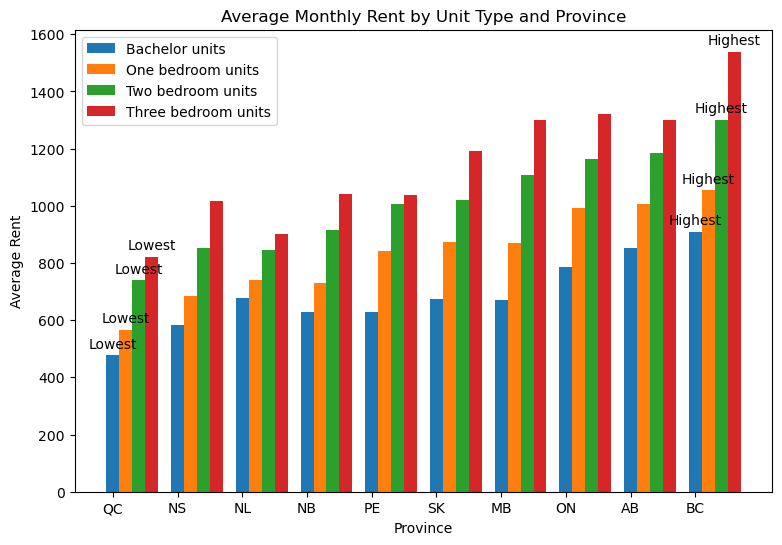

In [12]:
# First we aggregate the data to get the average rent for each unit type in each province
df1_pivot = df1.pivot_table(values='Rent', index='Province', columns='Unit', aggfunc=np.mean).reset_index()

# We sort the province by the average rent ascendingly. 
df1_pivot['Average_Rent'] = df1_pivot.iloc[:, 1:].mean(axis=1)
df1_pivot = df1_pivot.sort_values(by='Average_Rent').reset_index(drop=True)

# Define some local variables
num_provinces = len(df1_pivot)
unit_types = ['Bachelor units', 'One bedroom units', 'Two bedroom units', 'Three bedroom units']
bar_width = 0.2
area_indices = np.arange(num_provinces)
fig, ax = plt.subplots(figsize=(9, 6))

# We want to mark the highest and lowest rent for each unit type
max_values = df1_pivot[unit_types].max(axis=0)
min_values = df1_pivot[unit_types].min(axis=0)

# Plotting
for i, room in enumerate(unit_types):
    bars = ax.bar(area_indices + i * bar_width, df1_pivot[room], width=bar_width, label=room)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height == max_values[room]:
            ax.annotate('Highest',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom')
        if height == min_values[room]:
            ax.annotate('Lowest',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom')

# Setting the labels
ax.set_xlabel('Province')
ax.set_ylabel('Average Rent')
ax.set_title('Average Monthly Rent by Unit Type and Province')
ax.set_xticks(area_indices)
ax.set_xticklabels(df1_pivot['Province'])
ax.legend()

plt.show()

In [13]:
# Reference: QuantEcon Mapping in Python
try:
    import bokeh.io
    from bokeh.io import output_notebook
    from bokeh.plotting import figure, ColumnDataSource
    from bokeh.io import output_notebook, show, output_file
    from bokeh.plotting import figure
    from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
    from bokeh.palettes import brewer
    output_notebook()
    import json
except ImportError:
    ! pip install bokeh
canada_geo = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/canada.geojson')

canada_geo = canada_geo.rename(columns={'name': 'Province'})
translate_province(canada_geo)
rent_w_map = canada_geo.merge(df1_pivot, how="left").drop(columns = ["created_at", "updated_at"])
rent_w_map = rent_w_map.rename(columns={'Bachelor units': 'Bachelor_units', 'One bedroom units': 'One_bedroom_units',
                                        'Two bedroom units': 'Two_bedroom_units','Three bedroom units': 'Three_bedroom_units'})
rent_w_map = rent_w_map.fillna(0)
rent_geojson=GeoJSONDataSource(geojson=rent_w_map.to_json())
color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 400, high = 1400)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('Province','@Province'),
                               ('Bachelor units rent', '$@Bachelor_units{int}'),
                               ('One bedroom units rent', '$@One_bedroom_units{int}'),
                               ('Two bedroom units','$@Two_bedroom_units{int}'),
                               ('Three bedroom units','$@Three_bedroom_units{int}'),
                               ('Average Rent','$@Average_Rent{int}')])

p = figure(width=800, height=700, title="Rent in Canada by Province (No Data for YT, NT, NU)", tools=[hover])
p.patches("xs","ys",source=rent_geojson,
          fill_color = {'field' :'Average_Rent', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)


Loading BokehJS ...

In the graph above, we can see that Quebec has the lowest average rent for all kinds of room, whereas BC has the highest. New immigrants on a limited budget may choose Quebec, Maritimes Provinces and Prairie Provinces to get a lower rent.




### Income vs Cost of Living

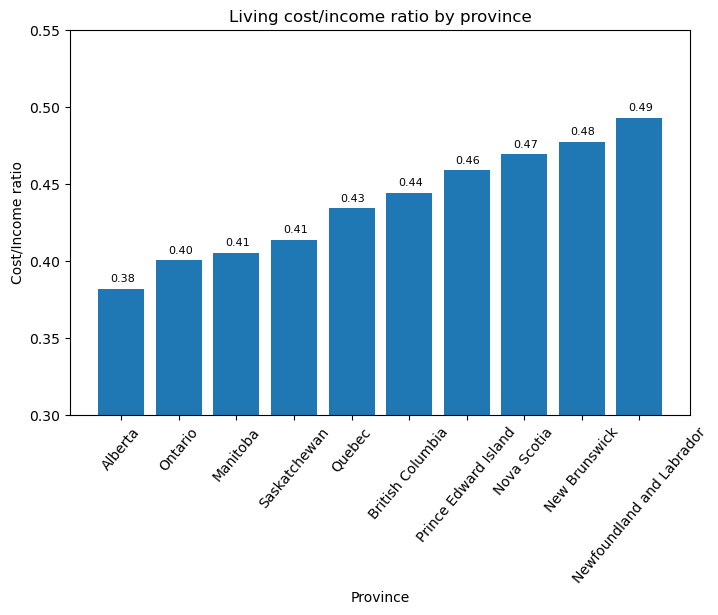

In [14]:
def convert_to_individual_income(row):
    population = row['Population']
    new_row = row.copy()
    new_row["Spending"] = (row["Spending"] * 1000000) / population
    new_row["cost_income_ratio"] = new_row["Spending"] / new_row["Income"] 
    return new_row
individual_income = income_vs_cost.apply(convert_to_individual_income, axis=1).sort_values("cost_income_ratio")
plt.figure(figsize=(8,5))
plt.bar(individual_income["Province"], individual_income["cost_income_ratio"])
plt.title("Living cost/income ratio by province")
plt.xlabel("Province")
plt.ylabel("Cost/Income ratio")
plt.ylim(0.3,0.55)
plt.xticks(rotation=50)
for prov, ratio in enumerate(individual_income["cost_income_ratio"]):
    plt.annotate(f"{ratio:.2f}", (prov, ratio), textcoords="offset points", xytext=(-8, 5), fontsize=8)
plt.show()

Alberta has the lowest Living cost/income ratio, where as Newfoundland and Labrador has the highest.